In [1]:
import scperturb as scp 
import urllib.request
import os
import scanpy as sc 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn
from gsnn_lib.proc import omnipath 
import pandas as pd
import torch

from gsnn.models.GSNN import GSNN 
from gsnn.models.NN import NN
from hnet.models.HyperNet import HyperNet

from gsnn_lib.proc.sc.load import get_SrivatsanTrapnell2020, load_scp_dataset
from gsnn_lib.data.scSampler import scSampler

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from hnet.train.hnet import init_hnet

import umap
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import gc 
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind

from geomloss import SamplesLoss
from scipy.stats import wasserstein_distance_nd

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK


In [2]:
vae = torch.load('../../output/sciplex3/vae/scvae.pt', weights_only=False).cpu()

In [3]:
k = 1
uid = 'fd47aa2c-5416-465f-981f-d44d828a421a'

res_dict = {i:torch.load(f'../../output/sciplex3/gsnn/{uid}/split_{i}/test_res_dict.pt', weights_only=False) for i in range(k)}

res = {} 
for cond_idx in res_dict[0].keys(): 
    res[cond_idx] = {'y0': np.concatenate(([res_dict[i][cond_idx]['y0'] for i in range(k)])),
                     'y': np.concatenate(([res_dict[i][cond_idx]['y'] for i in range(k)])),
                     'yhat': np.concatenate(([res_dict[i][cond_idx]['yhat'] for i in range(k)])),
                     'meta': res_dict[0][cond_idx]['meta']}
    

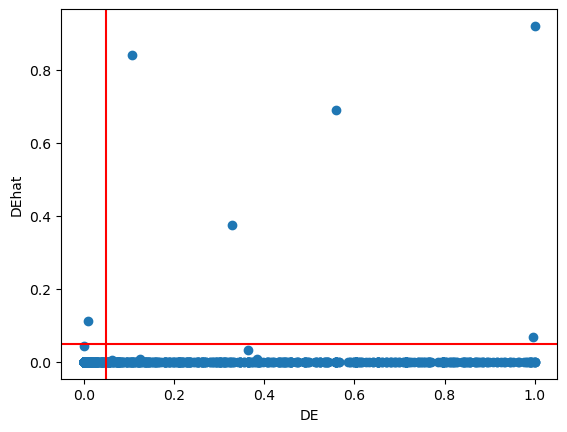

r 0.05733598149612698
# positives (true): 247
# positives (pred): 717
acc: 0.34716459197787


In [4]:
cond_idx = 19

y = res[cond_idx]['y']
y0 = res[cond_idx]['y0']
yhat = res[cond_idx]['yhat']

test = mannwhitneyu

# compute differential expression between y-y0 
de = np.ones(y.shape[1])
for i in range(y.shape[1]): 
    de[i] = test(y[:, i], y0[:, i])[1]

dehat = np.ones(yhat.shape[1])
for i in range(yhat.shape[1]): 
    dehat[i] = test(yhat[:, i], y0[:, i])[1]

plt.figure()
plt.plot(de, dehat, 'o')
plt.xlabel('DE')
plt.ylabel('DEhat')
#plt.xscale('log')
#plt.yscale('log')
plt.axvline(0.05, color='r')
plt.axhline(0.05, color='r')
plt.show()

print('r', np.corrcoef(de, dehat)[0, 1])

de_calls = de < 0.05
dehat_calls = dehat < 0.05

acc = np.sum(de_calls == dehat_calls) / de_calls.shape[0]

print('# positives (true):', np.sum(de_calls))
print('# positives (pred):', np.sum(dehat_calls))
print('acc:', acc)

In [5]:
ally = np.concatenate([res[i]['y'] for i in range(len(res))])
#ally0 = np.concatenate([res[i]['y0'] for i in range(len(res))])

#allyy0 = np.concatenate((ally, ally0), axis=0)

#reducer = umap.UMAP()
reducer = PCA(n_components=2)
reducer.fit(vae.encode(torch.tensor(ally).float()).detach().numpy())

PCA(n_components=2)

[-0.02640998  0.00987796 -0.15083122  0.02367609 -0.05309501]
R2 avg change between pops -0.24759316444396973


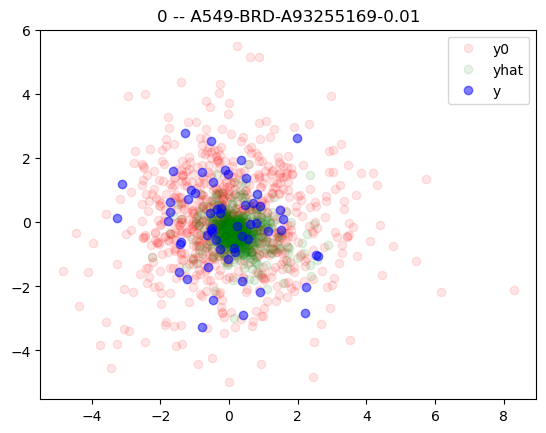

[0.01747969 0.1558229  0.01377222 0.00512658 0.00154379]
R2 avg change between pops -0.30582213401794434


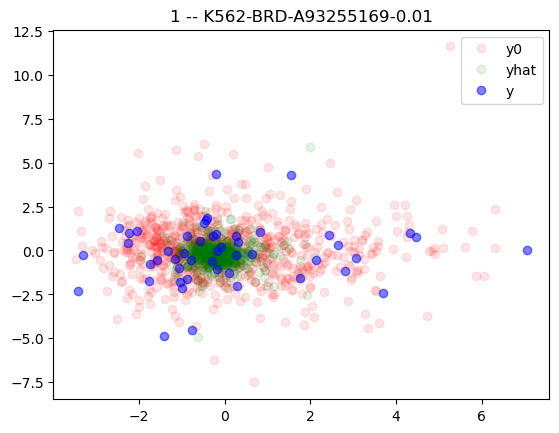

[ 0.12806307  0.07549974  0.06046443 -0.01282592  0.00881603]
R2 avg change between pops -1.8543660640716553


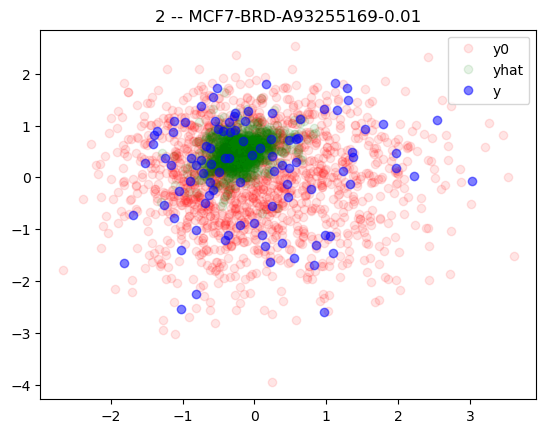

[-0.02709259  0.01043676 -0.1508764   0.02392068 -0.05301343]
R2 avg change between pops -0.2296086549758911


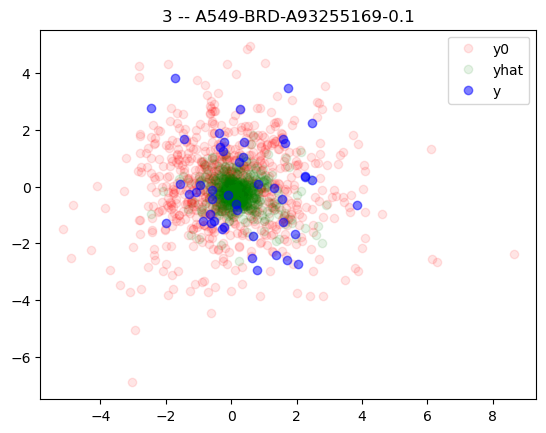

[0.01652497 0.15545358 0.01378435 0.00523953 0.00243682]
R2 avg change between pops -0.37523114681243896


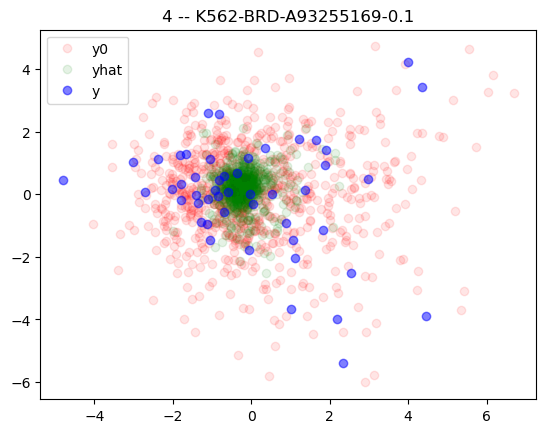

[ 0.12777154  0.07612707  0.06045803 -0.01258719  0.00978768]
R2 avg change between pops -1.7175424098968506


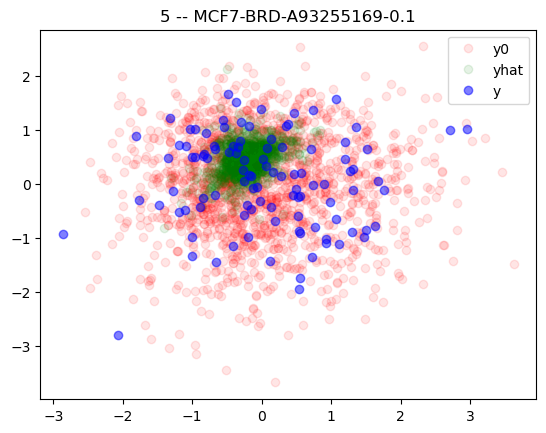

[-0.02760096  0.01092654 -0.15093207  0.02416299 -0.05320214]
R2 avg change between pops -0.17808127403259277


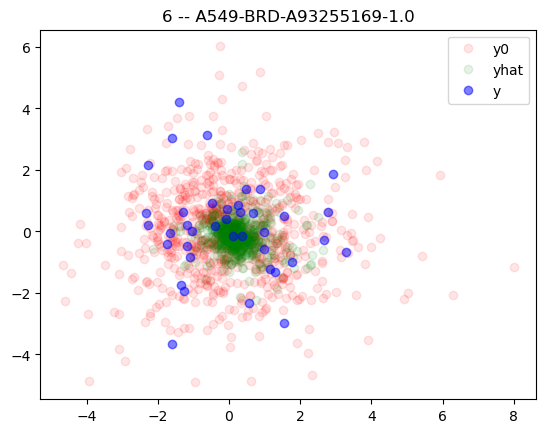

[0.01575455 0.15514994 0.01379307 0.00536154 0.00290763]
R2 avg change between pops -0.2697685956954956


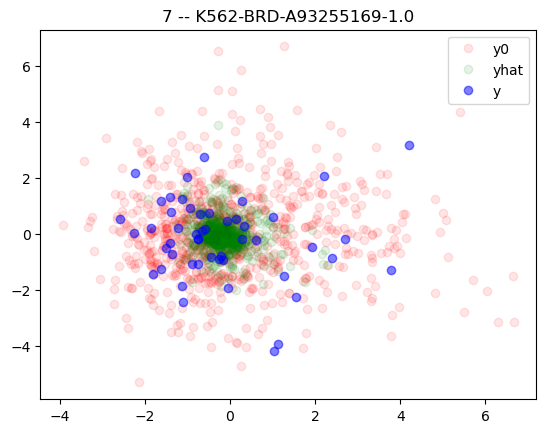

[ 0.12754865  0.07665567  0.06044964 -0.01237181  0.01042594]
R2 avg change between pops -1.533813714981079


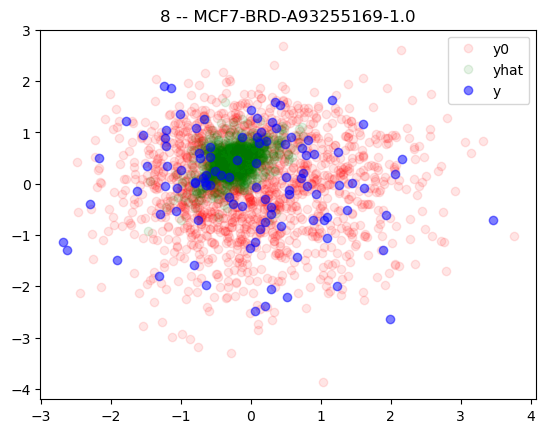

[-0.02796337  0.01136319 -0.15099007  0.02439874 -0.05354747]
R2 avg change between pops -0.06868422031402588


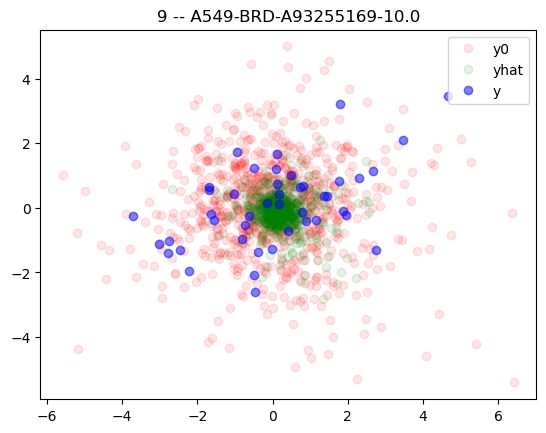

[0.01514351 0.15491515 0.01380004 0.00549156 0.00309594]
R2 avg change between pops -0.3654879331588745


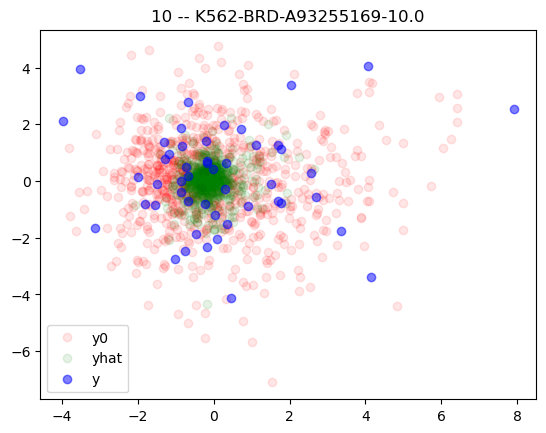

[ 0.127386    0.07710348  0.060441   -0.01217615  0.01082048]
R2 avg change between pops -1.5025627613067627


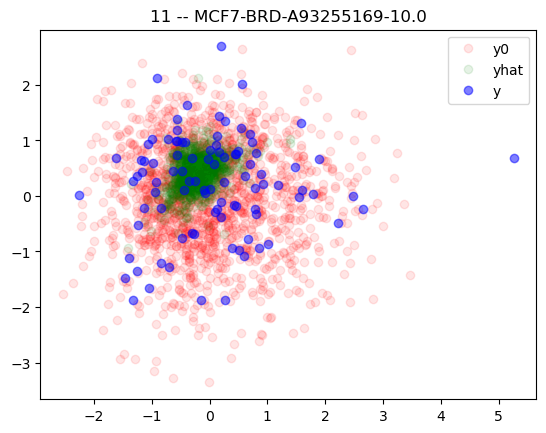

[-0.11417831 -0.0099773  -0.27716735  0.38648728 -0.30619532]
R2 avg change between pops -0.40918123722076416


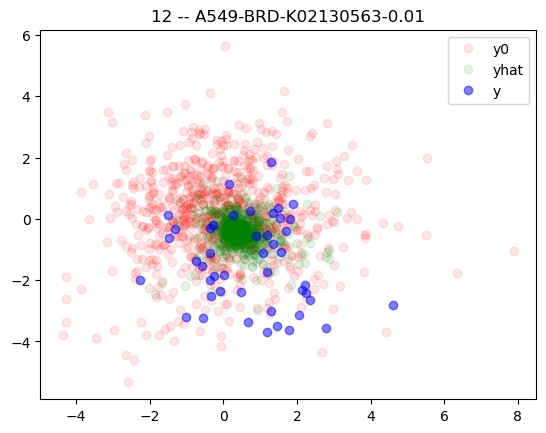

[-0.05615863  0.08760753  0.00875159  0.10034639 -0.18931186]
R2 avg change between pops -0.15154528617858887


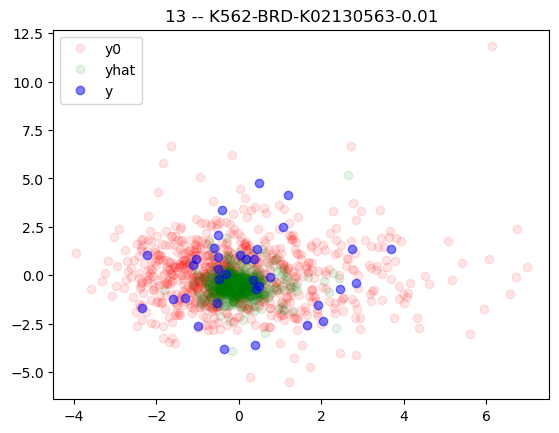

[ 0.03002186  0.05186143  0.0554267   0.30533856 -0.12015373]
R2 avg change between pops -1.0236446857452393


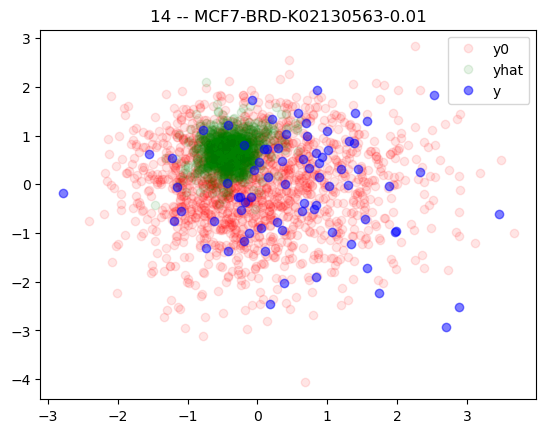

[-0.11460761 -0.00915159 -0.29586202  0.40240824 -0.3098577 ]
R2 avg change between pops 0.42570221424102783


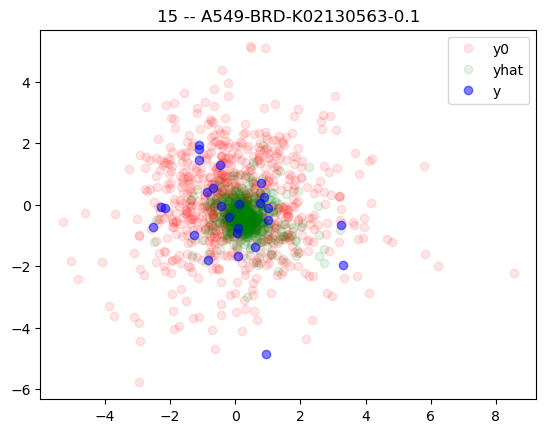

[-0.05678803  0.08832053  0.00864142  0.10118547 -0.19169797]
R2 avg change between pops 0.11760610342025757


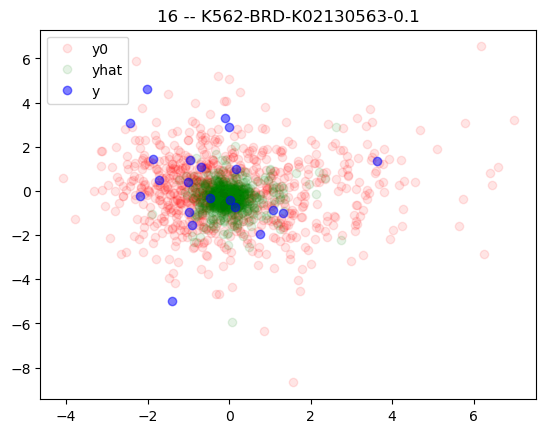

[ 0.02985038  0.05307258  0.0553724   0.32704407 -0.12159544]
R2 avg change between pops 0.3056008219718933


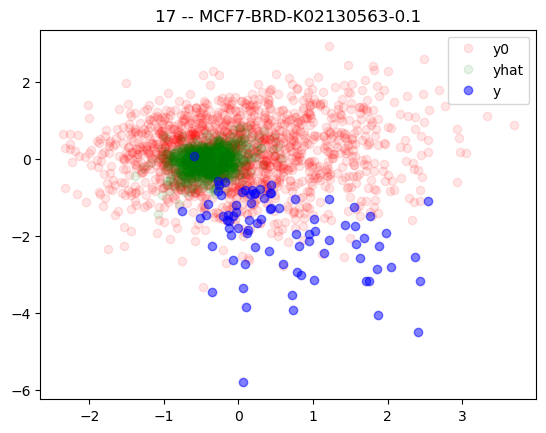

[-0.11495546 -0.0083712  -0.3101408   0.41270375 -0.31210977]
R2 avg change between pops 0.4363924264907837


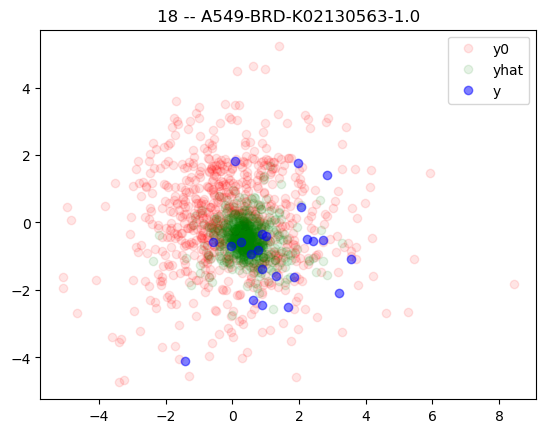

[ 0.02965307  0.05385067  0.05533941  0.3424015  -0.1224207 ]
R2 avg change between pops 0.3374980688095093


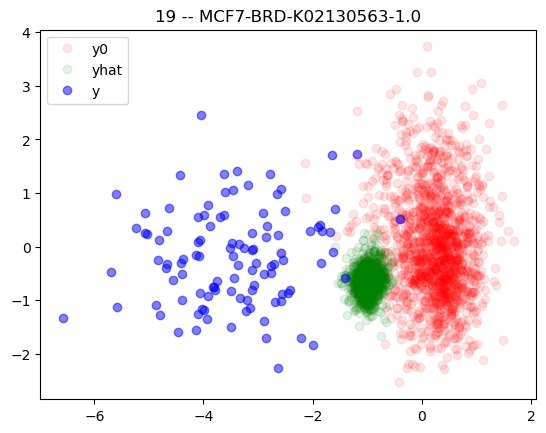

[-0.11522019 -0.00773199 -0.31986967  0.42005026 -0.31358048]
R2 avg change between pops 0.4363131523132324


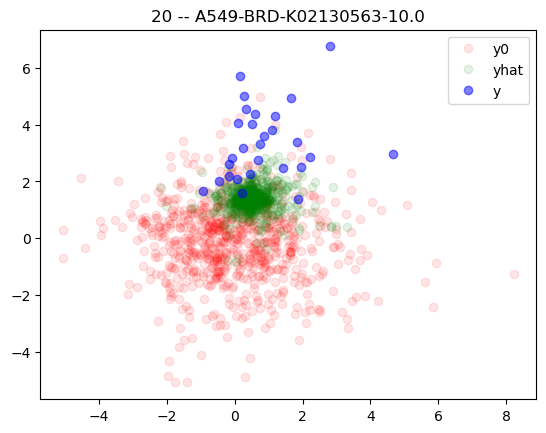

[ 0.02949232  0.05439636  0.05531675  0.35393232 -0.1229282 ]
R2 avg change between pops 0.32122790813446045


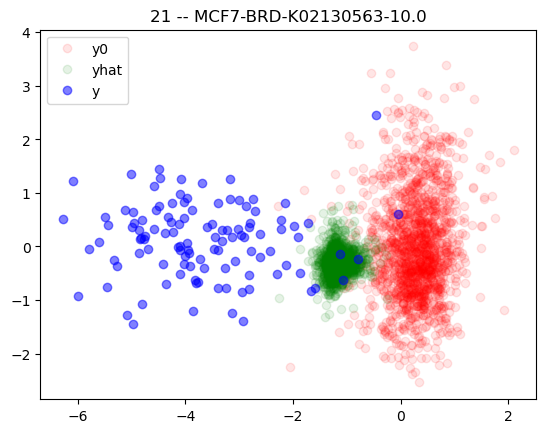

[-0.02237023  0.00554753 -0.1510359   0.02236054 -0.05913368]
R2 avg change between pops -0.18858599662780762


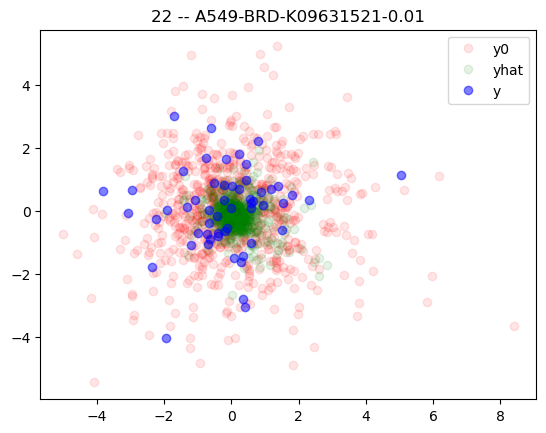

[ 0.02223843  0.15782365  0.01363158  0.00458426 -0.01045814]
R2 avg change between pops -0.3907463550567627


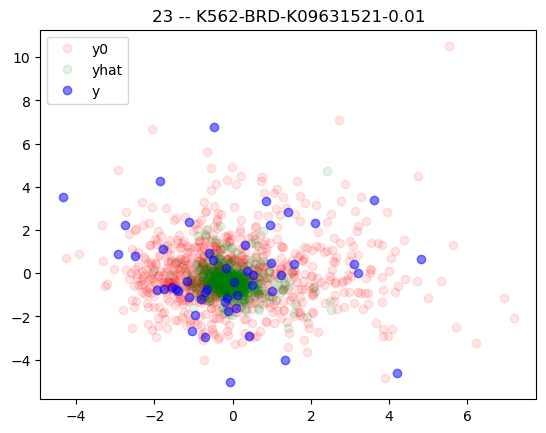

[ 1.2963104e-01  7.0635304e-02  6.0429633e-02 -1.4290113e-02
 -2.9802322e-08]
R2 avg change between pops -1.4350171089172363


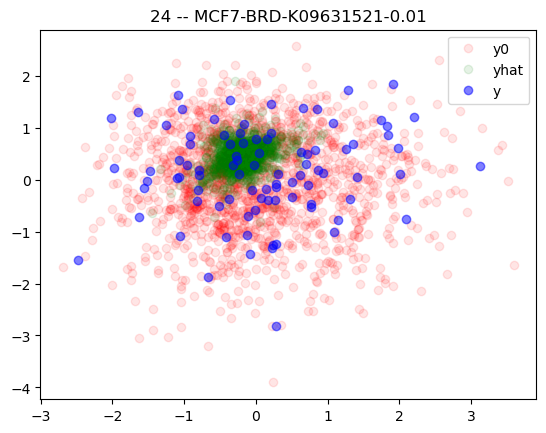

[-0.02237014  0.00554528 -0.1510359   0.02236106 -0.05913253]
R2 avg change between pops -0.10779666900634766


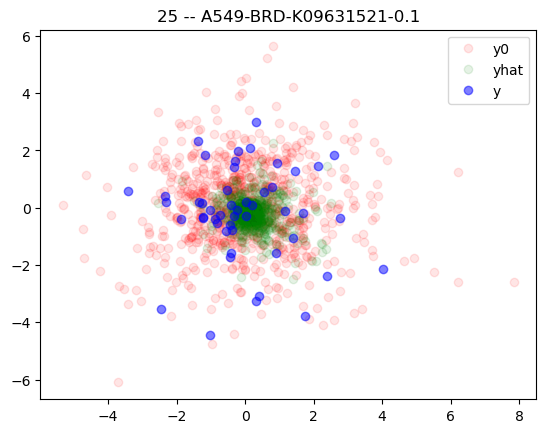

[ 0.02223822  0.15782315  0.01363157  0.00458303 -0.0104575 ]
R2 avg change between pops -0.2980470657348633


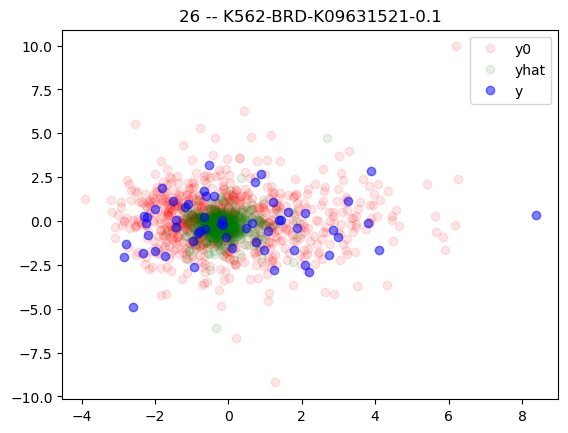

[ 1.2963100e-01  7.0635065e-02  6.0429588e-02 -1.4288047e-02
  5.5134296e-07]
R2 avg change between pops -1.1674275398254395


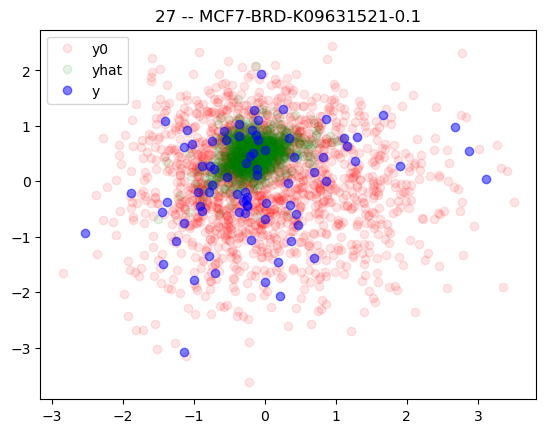

[-0.0223702   0.00554392 -0.1510359   0.02236129 -0.05913197]
R2 avg change between pops -0.17198121547698975


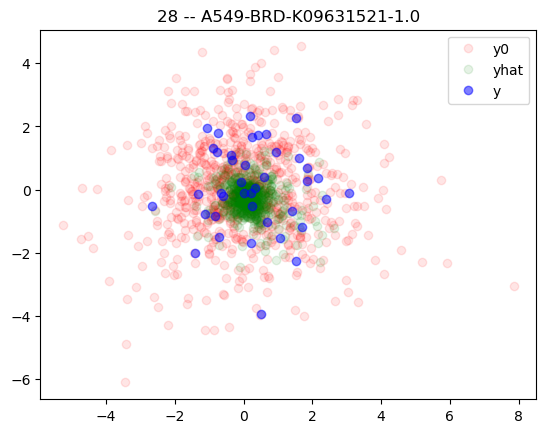

[ 0.02223799  0.15782279  0.01363157  0.00458221 -0.01045702]
R2 avg change between pops -0.3451197147369385


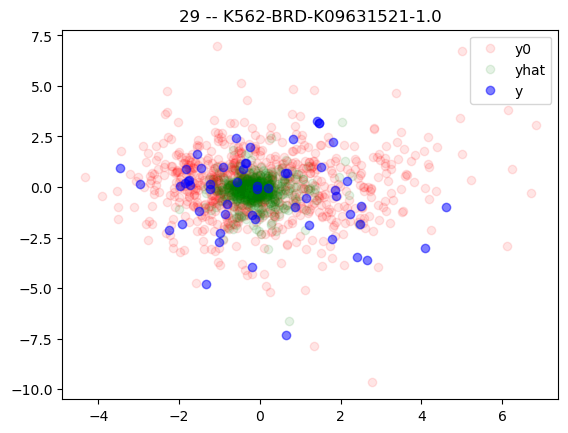

[ 1.2963103e-01  7.0634916e-02  6.0429573e-02 -1.4286645e-02
  9.3877316e-07]
R2 avg change between pops -0.7391785383224487


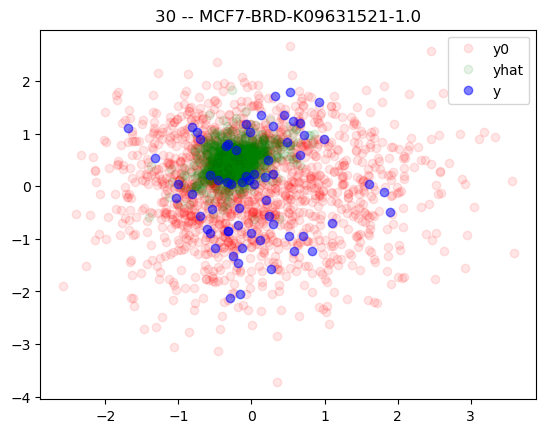

[-0.02237016  0.00554311 -0.15103602  0.02236149 -0.05913141]
R2 avg change between pops -0.07792019844055176


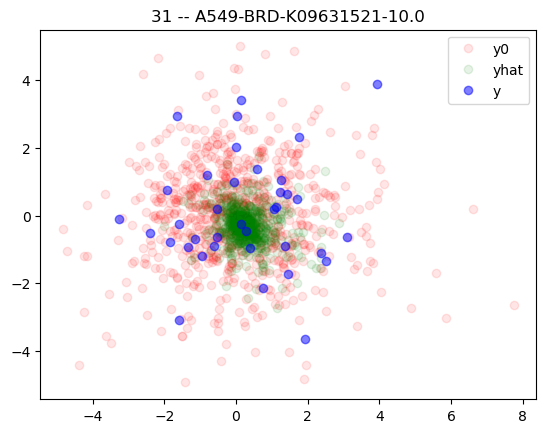

[ 0.02223784  0.1578226   0.01363158  0.00458163 -0.01045667]
R2 avg change between pops -0.2987246513366699


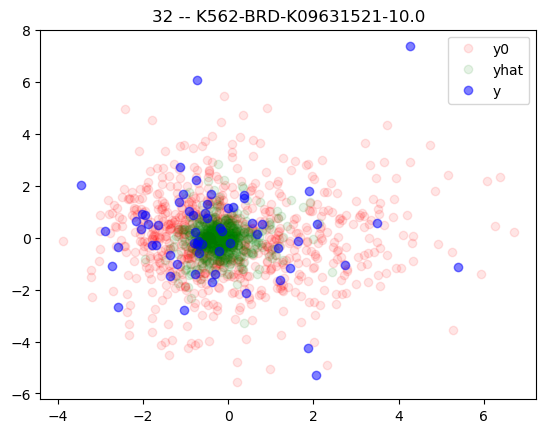

[ 1.2963103e-01  7.0634797e-02  6.0429588e-02 -1.4285639e-02
  1.1622906e-06]
R2 avg change between pops -1.3142571449279785


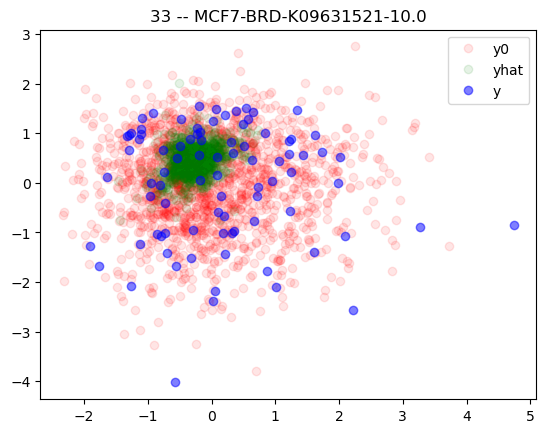

[-0.03047314  0.06397211 -0.1449964   0.01529771 -0.08958521]
R2 avg change between pops -0.046198487281799316


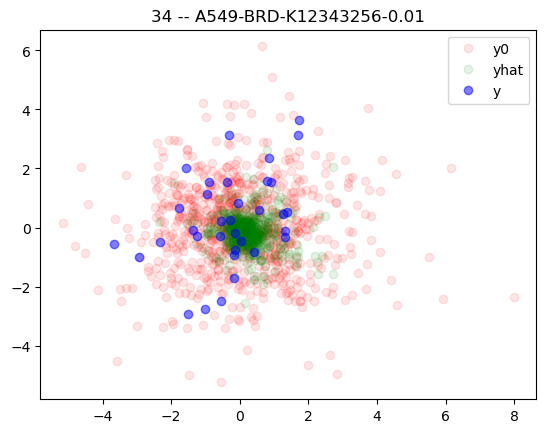

[ 0.01521969  0.23594964  0.01442106  0.00164703 -0.02862926]
R2 avg change between pops 0.22113817930221558


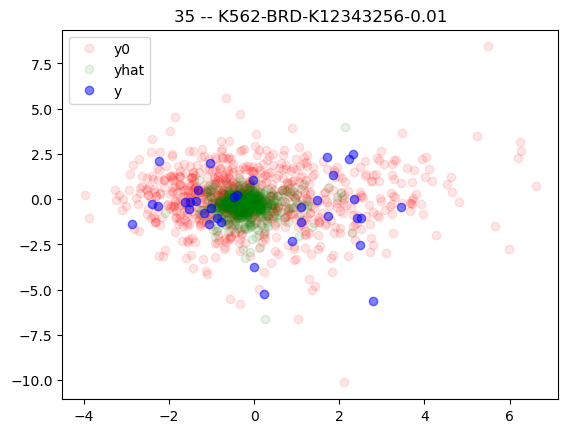

[ 0.12369375  0.1383507   0.06086074 -0.02378066 -0.00432719]
R2 avg change between pops -0.979392409324646


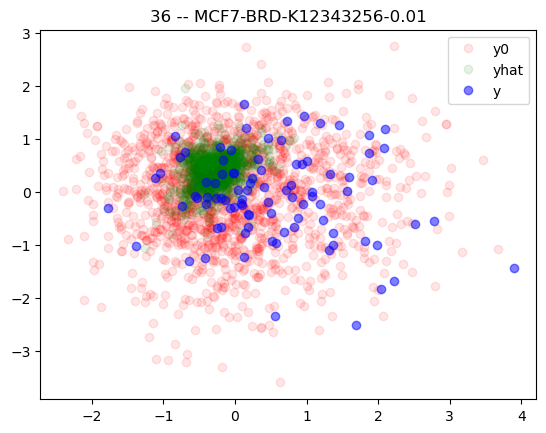

[-0.03077103  0.06862722 -0.14476877  0.01471661 -0.09087829]
R2 avg change between pops -0.04072844982147217


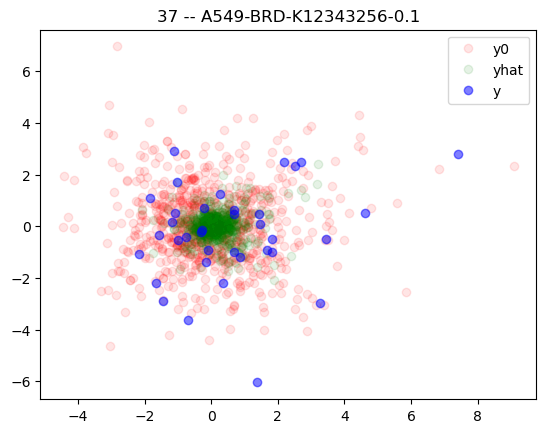

[ 0.01472184  0.24224433  0.01446988  0.00124684 -0.0297031 ]
R2 avg change between pops 0.1913800835609436


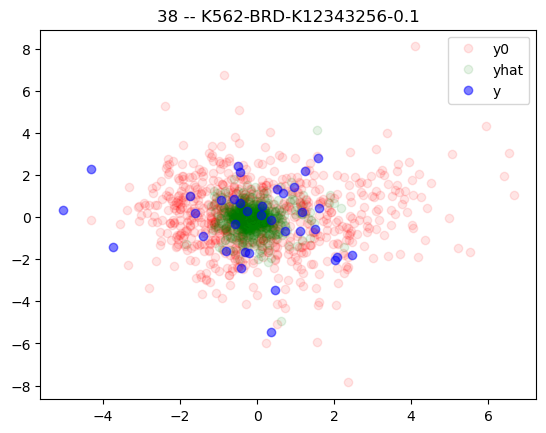

[ 0.12337483  0.1444087   0.0608823  -0.02430137 -0.00474441]
R2 avg change between pops -0.9409284591674805


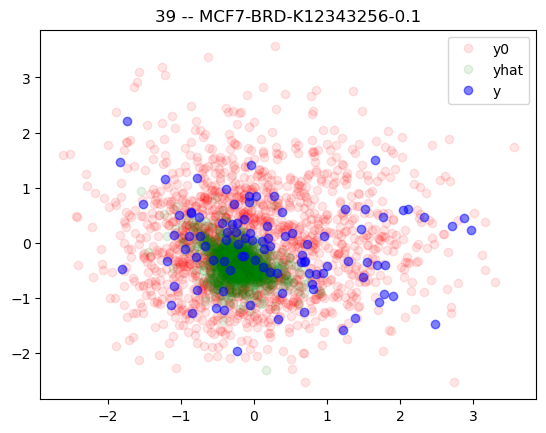

[-0.03093752  0.071697   -0.14462721  0.01430193 -0.09164512]
R2 avg change between pops -0.017688632011413574


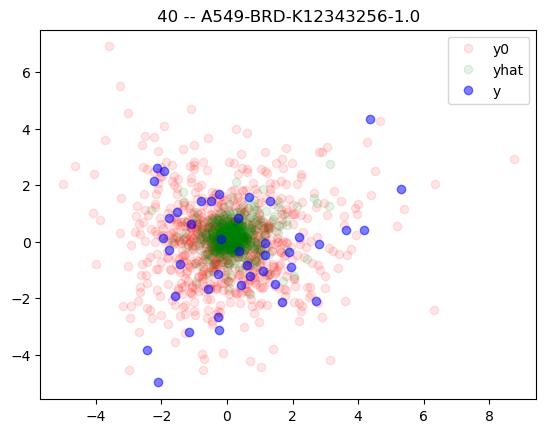

[ 0.01441661  0.24638061  0.01450107  0.00096265 -0.03025989]
R2 avg change between pops 0.22260504961013794


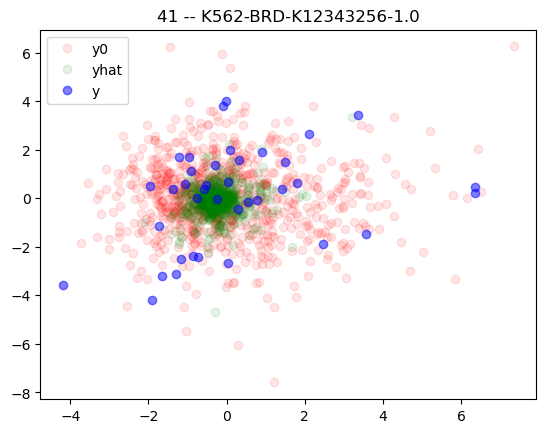

[ 0.12317301  0.14844078  0.06089365 -0.02467454 -0.00499122]
R2 avg change between pops -0.9874477386474609


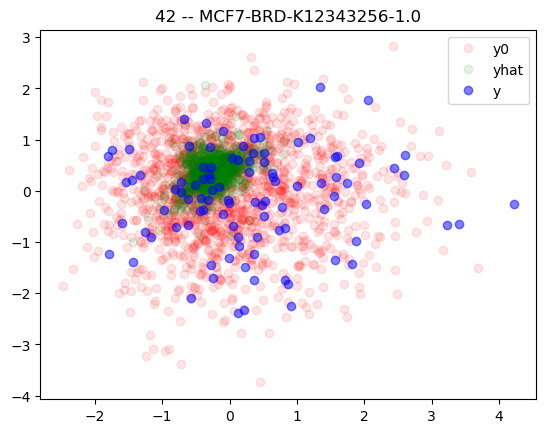

[-0.03104623  0.07386168 -0.14452177  0.01399541 -0.09213056]
R2 avg change between pops -0.037724852561950684


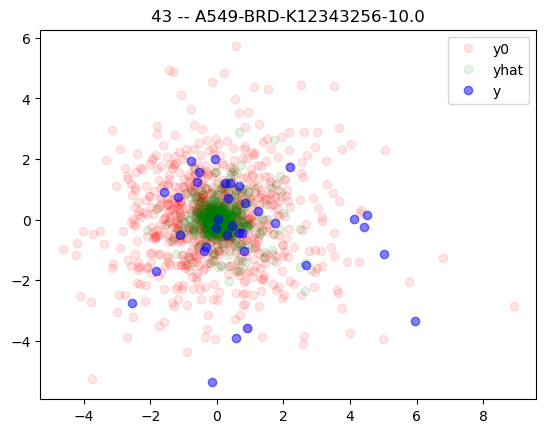

[ 0.01420844  0.24929309  0.01452413  0.00075229 -0.03055471]
R2 avg change between pops 0.2019345760345459


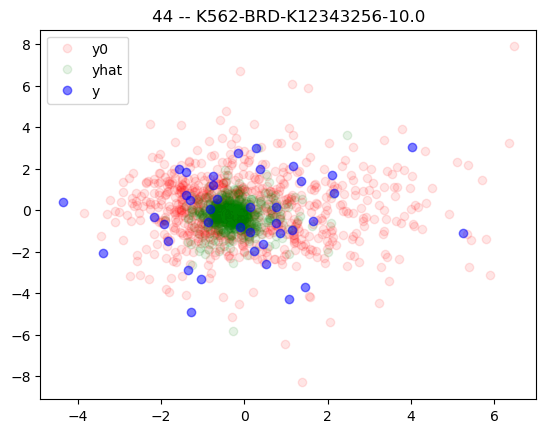

[ 0.12302789  0.15130903  0.06090131 -0.02495618 -0.00513063]
R2 avg change between pops -0.9073891639709473


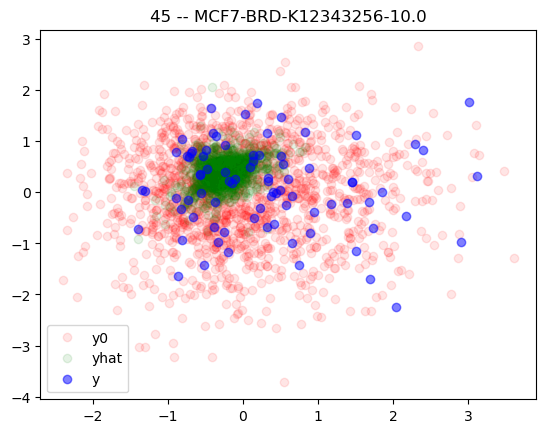

[-0.01959994  0.02030133 -0.13603836  0.09077159 -0.05084425]
R2 avg change between pops -0.24333882331848145


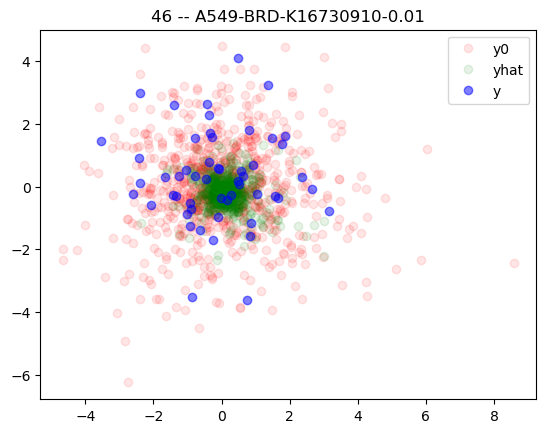

[0.01662132 0.16528931 0.01412836 0.03801336 0.00601557]
R2 avg change between pops -0.29550862312316895


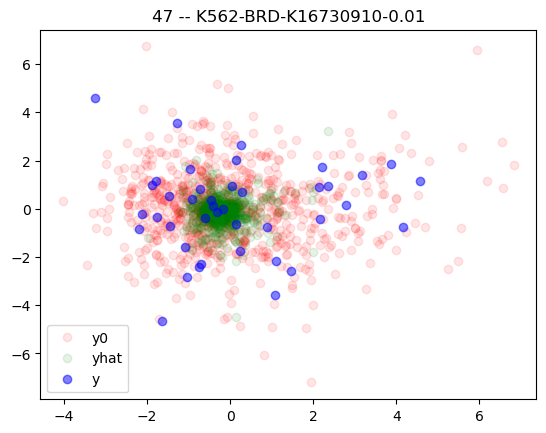

[0.13053235 0.08395803 0.06186792 0.06369697 0.01805699]
R2 avg change between pops -1.3835523128509521


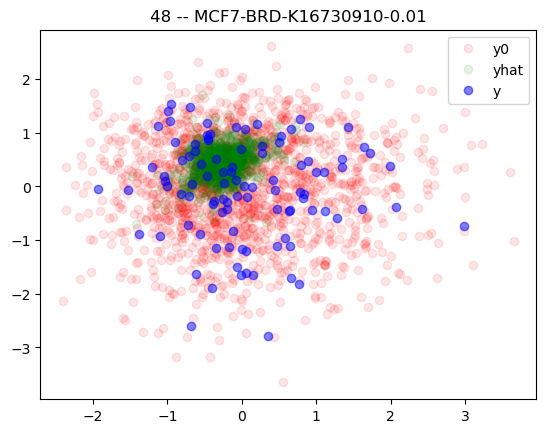

[-0.01902029  0.02104214 -0.13543755  0.09833792 -0.05082166]
R2 avg change between pops -0.22127962112426758


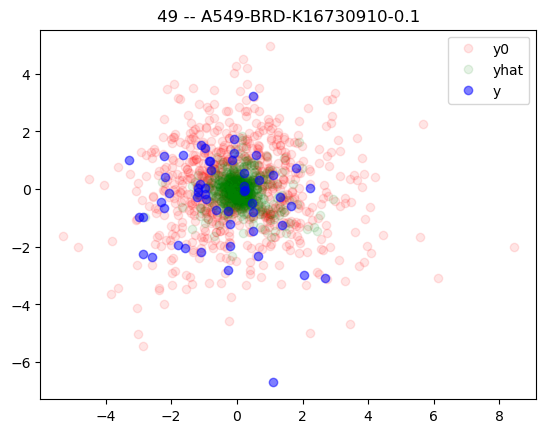

In [6]:
for i in range(50): 

    y = res[i]['y']
    y0 = res[i]['y0']
    yhat = res[i]['yhat']
    deltahat = yhat.mean(0) - y0.mean(0)
    print(deltahat[0:5])
    delta = y.mean(0) - y0.mean(0)
    print('R2 avg change between pops', r2_score(delta, deltahat))

    reducer = PCA(n_components=2)

    yy0 = torch.cat([torch.tensor(y0).float(), torch.tensor(y).float()])
    label = np.concatenate([np.zeros(y0.shape[0]), np.ones(y.shape[0])])
    reducer.fit(vae.encode(yy0).detach().numpy())

    uy = reducer.transform(vae.encode(torch.tensor(res[i]['y']).float()).detach().numpy())
    uy0 = reducer.transform(vae.encode(torch.tensor(res[i]['y0']).float()).detach().numpy())
    uyhat = reducer.transform(vae.encode(torch.tensor(res[i]['yhat']).float()).detach().numpy())

    plt.figure()
    
    plt.plot(uy0[:,0], uy0[:,1], 'o', color='red', alpha=0.1, label='y0')
    plt.plot(uyhat[:,0], uyhat[:,1], 'o', color='green', alpha=0.1, label='yhat')
    plt.plot(uy[:,0], uy[:,1], 'o', color='blue', alpha=0.5, label='y')
    
    plt.title(f'{i} -- {res[i]['meta']['cell_line']}-{res[i]['meta']['pert_id']}-{res[i]['meta']['dose_um']}')
    plt.legend()
    plt.show() 

In [2]:
fnames = os.listdir('../../sc_data/PROC/')
drugs = np.unique([f.split('_')[2] for f in fnames])[:-1] 
data = torch.load('../../sc_data/' + 'data.pt')

In [ ]:
model = torch.load('../../output/sciplex3/gsnn/aa0d7c4e-cdab-4d66-a073-c881cc47b862/best_model.pt')

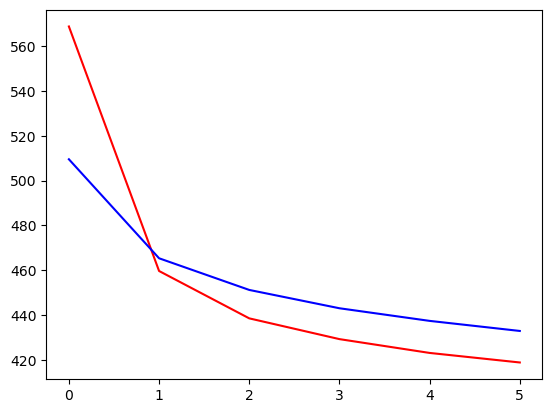

In [4]:
plt.figure()
plt.plot(res_dict['train_losses'], 'r-', label='train')
plt.plot(res_dict['val_losses'], 'b-', label='val')
plt.legend()
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


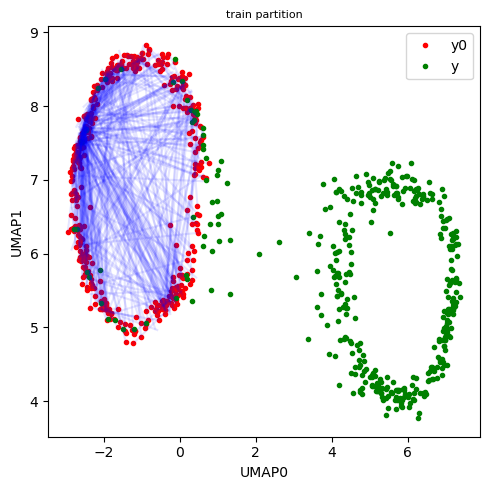

In [5]:
#BRD-K56957086, MCF7, 10000.0
#idd = sampler.conditions[lambda x: (x.drug == 'BRD-K56957086') & (x.cell_line == 'MCF7.') & (x.dose == 10000.0)].index[0]
idd = sampler.conditions[lambda x: (x.drug == 'BRD-K56957086') & (x.cell_line == 'MCF7.') & (x.dose == 10000.0)].index[0]
X,y = sampler.sample(idd, batch_size=500, partition='train')

with torch.no_grad():
    y0 = X[:, data.X2Y0_idxs]
    yhat = [] 
    for idx in torch.split(torch.arange(X.shape[0]), 50):
        yhat.append(T(X[idx].cuda()).detach().cpu())
    yhat = torch.cat(yhat) + y0

reducer = umap.UMAP()
reducer.fit(torch.cat([y0, y]).detach().cpu().numpy())
pc_y0 = reducer.transform(y0.detach().cpu().numpy())
pc_y = reducer.transform(y.detach().cpu().numpy())
pc_yhat = reducer.transform(yhat.detach().cpu().numpy())

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = [ax]
ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
for ii in range(pc_y0.shape[0]): 
    ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
ax[0].set_xlabel('UMAP0')
ax[0].set_ylabel('UMAP1')
ax[0].set_title(f'train partition', fontsize=8)
ax[0].legend()

plt.tight_layout()
plt.show()

In [ ]:
res = {'drug': [], 'cell_line': [], 'dose': [], 'shd': [], 'emmd': [], 'gmmd': [], 'n':[], 'wass':[], 'condition':[], 'shd0':[], 'emmd0':[], 'gmmd0':[], 'wass0':[], 'dbar':[]}

SHD = SamplesLoss('sinkhorn', p=2, blur=0.05, reach=None)
eMMD = SamplesLoss('energy') 
gMMD = SamplesLoss('gaussian', blur=0.05) 

for i in range(len(sampler)):
    print(f'progress: {i}/{len(sampler)}', end='\r')

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='test')
        y0 = X[:, data.X2Y0_idxs]
        yhat = [] 
        for idx in torch.split(torch.arange(X.shape[0]), 50):
            yhat.append(T(X[idx].cuda()).detach().cpu())
        yhat = torch.cat(yhat) + y0

    dbar = torch.mean((y.mean(0) - y0.mean(0))**2).item()*(0.5)

    shd = SHD(y, yhat).item()
    emmd = eMMD(y, yhat).item()
    gmmd = gMMD(y, yhat).item()
    wass = wasserstein_distance_nd(y.numpy(), yhat.numpy())

    shd0 = SHD(y, y0).item()
    emmd0 = eMMD(y, y0).item()
    gmmd0 = gMMD(y, y0).item()
    wass0 = wasserstein_distance_nd(y.numpy(), y0.numpy())

    res['drug'].append(drg_)
    res['cell_line'].append(cell_)
    res['dose'].append(dose_)
    res['condition'].append(i)

    res['shd'].append(shd)
    res['emmd'].append(emmd)
    res['gmmd'].append(gmmd)
    res['wass'].append(wass)

    res['n'].append(X.shape[0])
    res['dbar'].append(dbar)

    res['shd0'].append(shd0)
    res['emmd0'].append(emmd0)
    res['gmmd0'].append(gmmd0)
    res['wass0'].append(wass0)

    del X, y, y0, yhat

res = pd.DataFrame(res)
res.head()

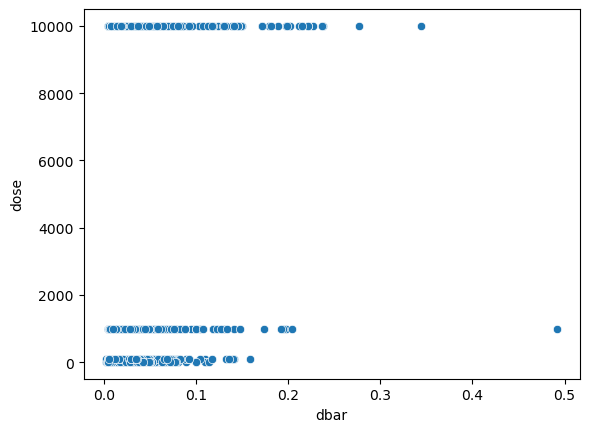

In [6]:
plt.figure()
sbn.scatterplot(data=res, x='dbar', y='dose')
plt.show()

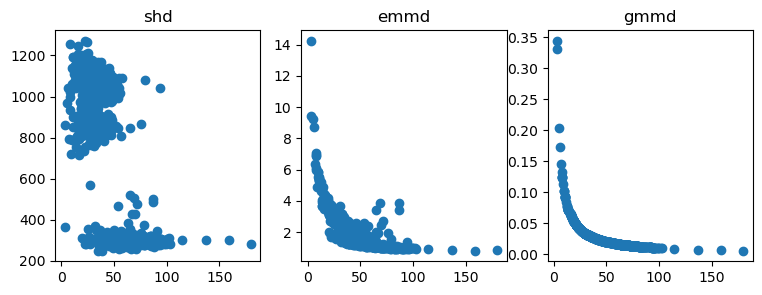

In [7]:
f,axes = plt.subplots(1,3, figsize=(9,3))
for i,metric in enumerate(['shd', 'emmd', 'gmmd']):
    axes[i].scatter(res['n'], res[metric])
    axes[i].set_title(metric)

plt.show()

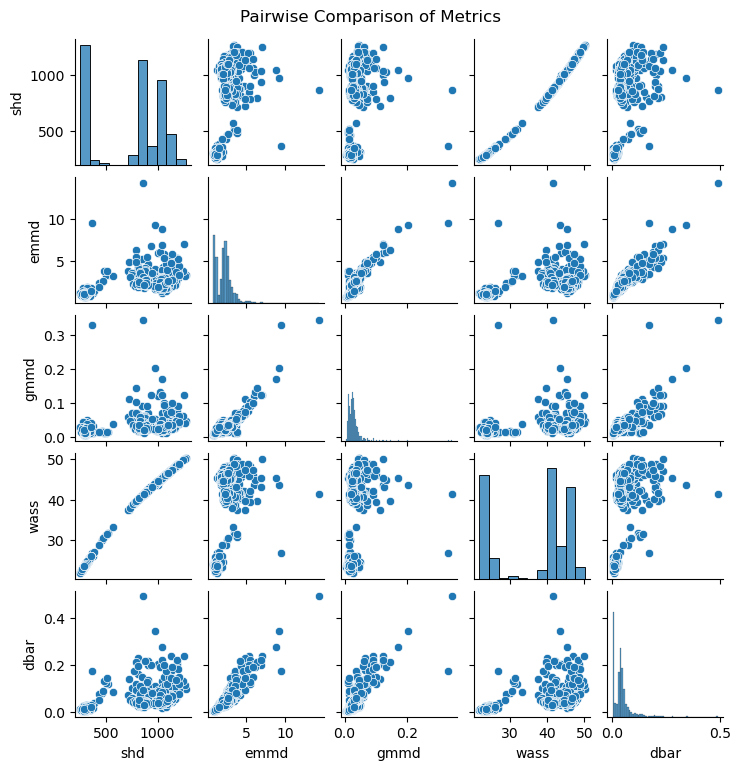

In [8]:
# Create a pairplot to compare each metric to each other
sbn.pairplot(res[['shd', 'emmd', 'gmmd', 'wass', 'dbar']], height=1.5)
plt.suptitle('Pairwise Comparison of Metrics', y=1.02)
plt.show()

In [9]:
res[lambda x: x.n > 25].sort_values('shd', ascending=True).head()

drug cell_line    dose         shd      emmd      gmmd   n  \
41   BRD-A60197193     MCF7.   100.0  248.453964  1.286280  0.025688  39   
692  BRD-K71512533     MCF7.  1000.0  249.440582  1.329420  0.028596  35   
272  BRD-K15574380     MCF7.  1000.0  258.156860  1.017563  0.015146  66   
617  BRD-K55187425     MCF7.   100.0  258.276428  1.087606  0.018219  55   
917  BRD-K97399794     MCF7.   100.0  259.466858  1.042763  0.014078  71   

          wass  condition        shd0     emmd0     gmmd0      wass0      dbar  
41   21.869971         41  243.761520  0.638805  0.025650  21.641776  0.008961  
692  21.955620        692  243.773956  0.690132  0.028661  21.630770  0.011324  
272  22.331235        272  246.594330  0.343794  0.015136  21.790010  0.005382  
617  22.198755        617  253.715469  0.455963  0.018223  21.884191  0.007778  
917  22.380618        917  241.725525  0.332218  0.014109  21.604063  0.005565

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


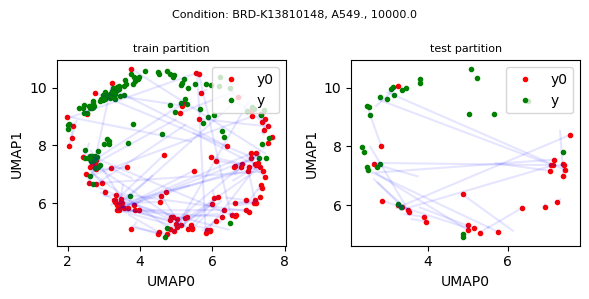

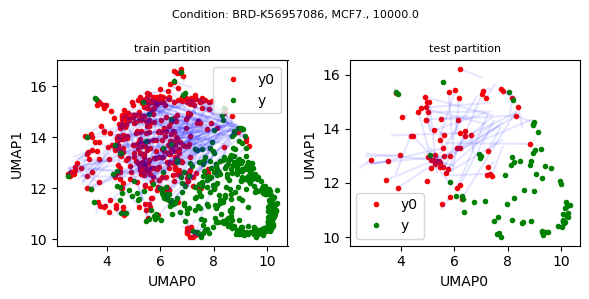

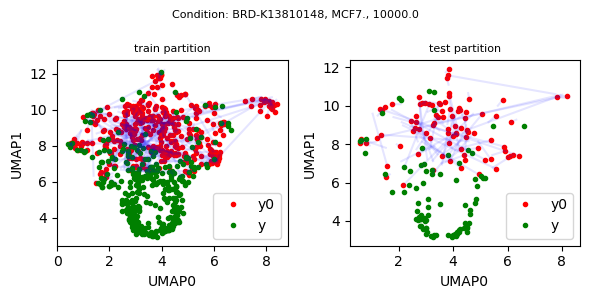

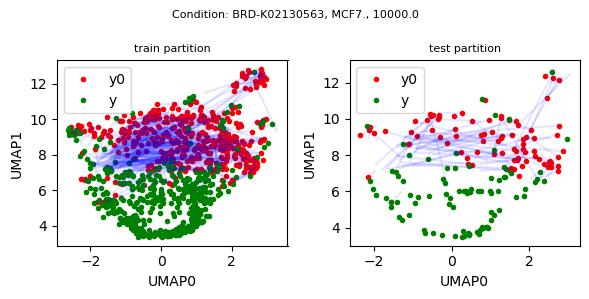

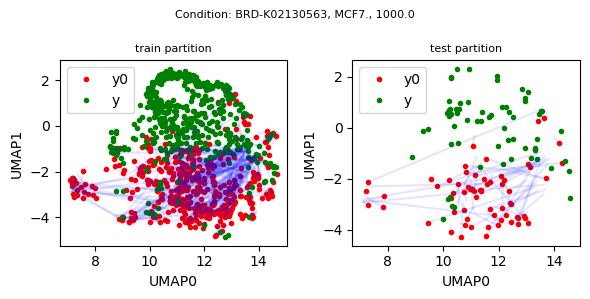

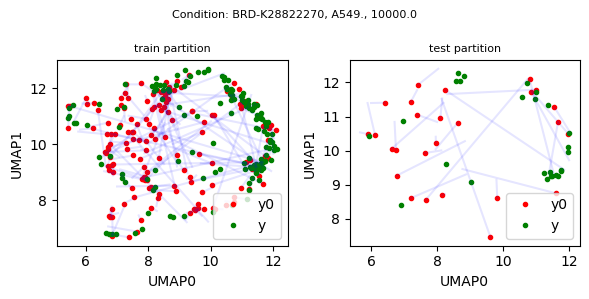

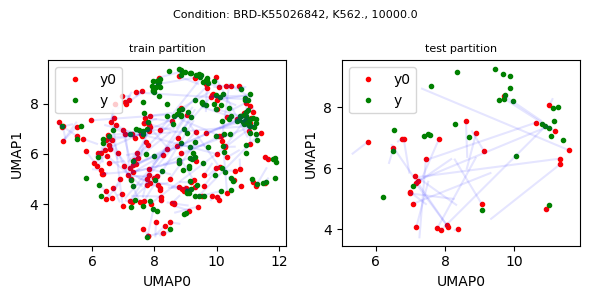

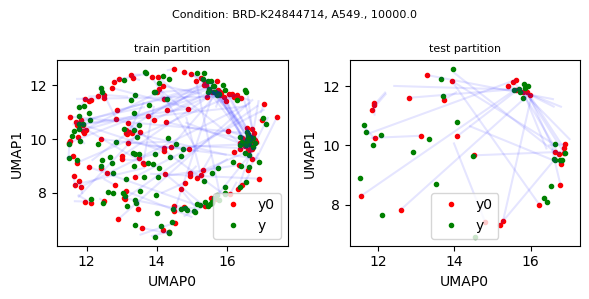

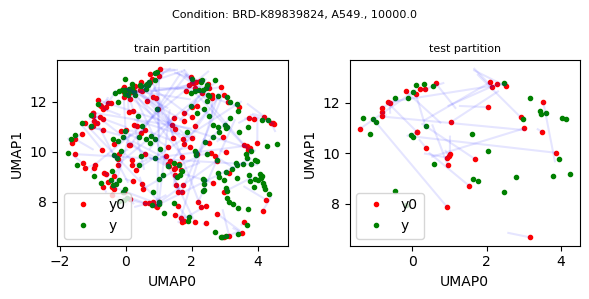

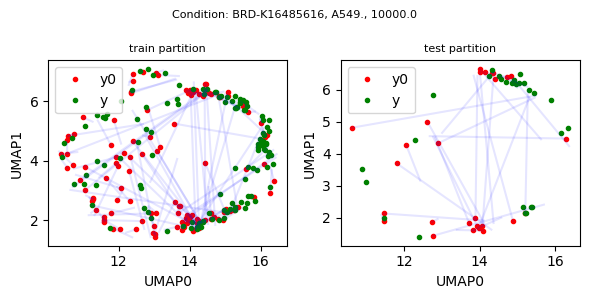

In [10]:
# todo: PLOT TRAIN/TEST

# strong perturbation conditions 
conds = res[lambda x: x.n > 25].sort_values('dbar', ascending=False).condition.values[0:10]
#conds = res[lambda x: x.n > 25].sort_values('shd', ascending=True).condition.values[0:10]

for i in conds: # range(len(sampler))[:1]:

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='train')
        Xt,yt = sampler.sample(i, batch_size=500, partition='test')

        delta = []
        for idx in torch.split( torch.arange(X.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            delta.append(T(X[idx].to(device)).cpu())
        delta = torch.cat(delta, dim=0)

        deltat = []
        for idx in torch.split( torch.arange(Xt.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            deltat.append(T(Xt[idx].to(device)).cpu())
        deltat = torch.cat(deltat, dim=0)

    y0 = X[:, data.X2Y0_idxs].detach().cpu().numpy() 
    y = y.detach().cpu().numpy()
    yhat = delta.detach().cpu().numpy() + y0

    y0t = Xt[:, data.X2Y0_idxs].detach().cpu().numpy() 
    yt = yt.detach().cpu().numpy()
    yhatt = deltat.detach().cpu().numpy() + y0t

    # dim red on each condition to better separate perturbation effects 
    # fit on training data (more available)
    # NOTE: using supervised umap to better separate pre- / post- perturbation states - otherwise cell cycle is often a primary source of variance 
    reducer = umap.UMAP(n_components=2)
    target = np.concatenate((np.ones_like(y0[:, 0]), np.zeros_like(y[:, 0])), axis=0)
    #pcs = reducer.fit(np.concatenate([y0, y], axis=0), y=target)
    pcs = reducer.fit(np.concatenate([y0, y, yhat], axis=0))

    pc_y0 = reducer.transform(y0)
    pc_y = reducer.transform(y)
    pc_yhat = reducer.transform(yhat)

    pc_y0t = reducer.transform(y0t)
    pc_yt = reducer.transform(yt)
    pc_yhatt = reducer.transform(yhatt)

    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
    ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
    for ii in range(pc_y0.shape[0]): 
        ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
    ax[0].set_xlabel('UMAP0')
    ax[0].set_ylabel('UMAP1')
    ax[0].set_title(f'train partition', fontsize=8)
    ax[0].legend()

    ax[1].plot(pc_y0t[:, 0], pc_y0t[:, 1], 'r.', label='y0')
    ax[1].plot(pc_yt[:, 0], pc_yt[:, 1], 'g.', label='y')
    for ii in range(pc_y0t.shape[0]): 
        ax[1].plot((pc_y0t[ii, 0], pc_yhatt[ii, 0]), (pc_y0t[ii, 1], pc_yhatt[ii, 1]), 'b-', alpha=0.1)
    ax[1].set_xlabel('UMAP0')
    ax[1].set_ylabel('UMAP1')
    ax[1].set_title(f'test partition', fontsize=8)
    ax[1].legend()

    plt.suptitle(f'Condition: {drg_}, {cell_}, {dose_}', fontsize=8)

    plt.tight_layout()
    plt.show()


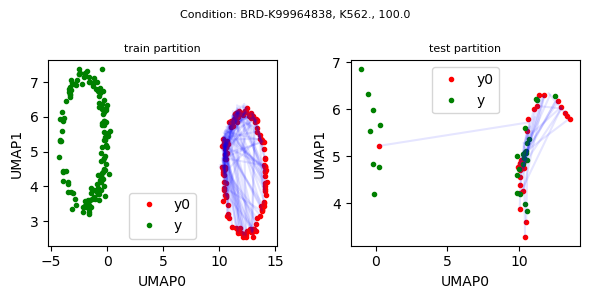

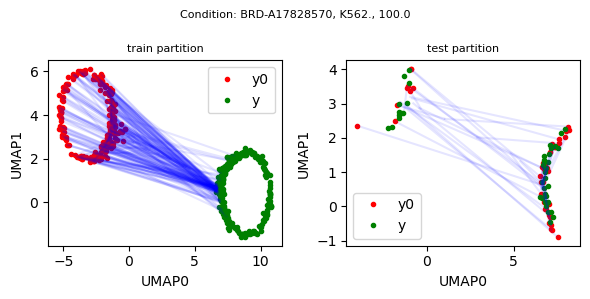

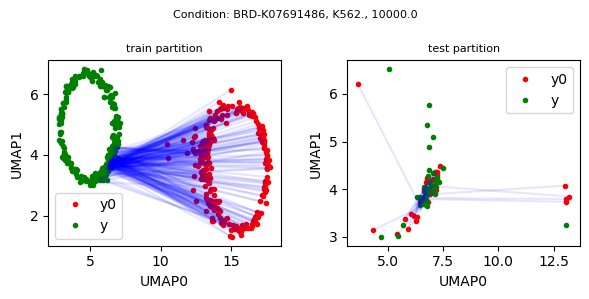

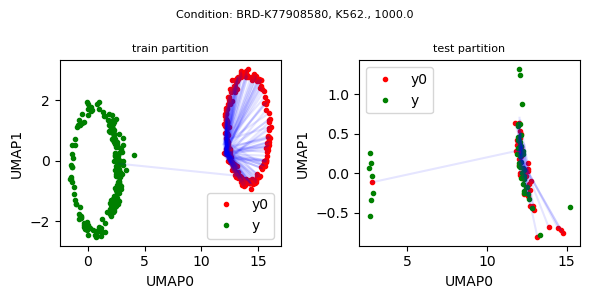

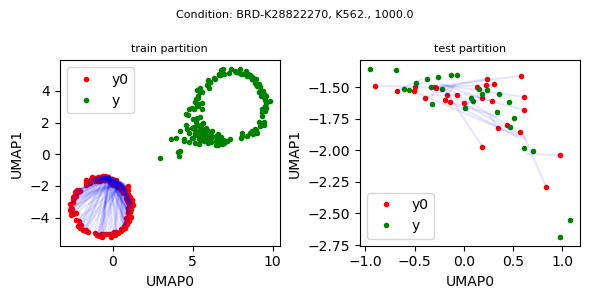

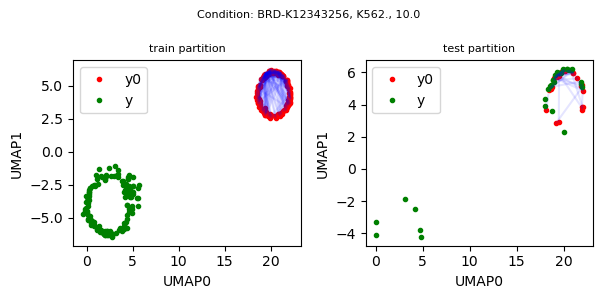

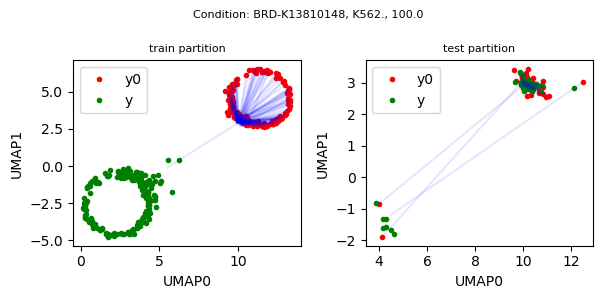

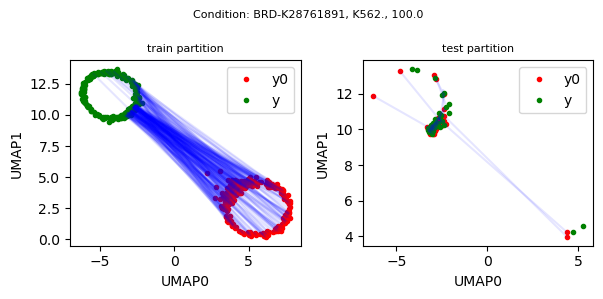

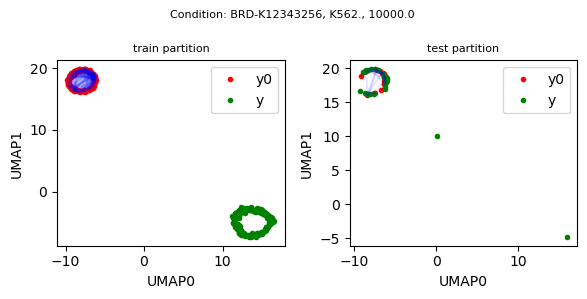

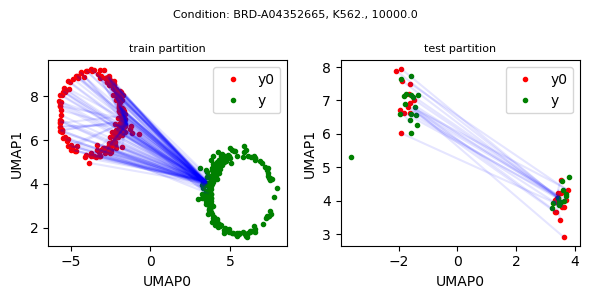

In [11]:
# todo: PLOT TRAIN/TEST

# strong perturbation conditions 
#conds = res[lambda x: x.n > 25].sort_values('dbar', ascending=False).condition.values[0:3]
conds = res[lambda x: x.n > 25].sort_values('shd', ascending=True).condition.values[-10:]

for i in conds: # range(len(sampler))[:1]:

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='train')
        Xt,yt = sampler.sample(i, batch_size=500, partition='test')

        delta = []
        for idx in torch.split( torch.arange(X.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            delta.append(T(X[idx].to(device)).cpu())
        delta = torch.cat(delta, dim=0)

        deltat = []
        for idx in torch.split( torch.arange(Xt.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            deltat.append(T(Xt[idx].to(device)).cpu())
        deltat = torch.cat(deltat, dim=0)

    y0 = X[:, data.X2Y0_idxs].detach().cpu().numpy() 
    y = y.detach().cpu().numpy()
    yhat = delta.detach().cpu().numpy() + y0

    y0t = Xt[:, data.X2Y0_idxs].detach().cpu().numpy() 
    yt = yt.detach().cpu().numpy()
    yhatt = deltat.detach().cpu().numpy() + y0t

    # dim red on each condition to better separate perturbation effects 
    # fit on training data (more available)
    # NOTE: using supervised umap to better separate pre- / post- perturbation states - otherwise cell cycle is often a primary source of variance 
    reducer = umap.UMAP(n_components=2)
    target = np.concatenate((np.ones_like(y0[:, 0]), np.zeros_like(y[:, 0])), axis=0)
    pcs = reducer.fit(np.concatenate([y0, y], axis=0), y=target)

    pc_y0 = reducer.transform(y0)
    pc_y = reducer.transform(y)
    pc_yhat = reducer.transform(yhat)

    pc_y0t = reducer.transform(y0t)
    pc_yt = reducer.transform(yt)
    pc_yhatt = reducer.transform(yhatt)

    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
    ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
    for ii in range(pc_y0.shape[0]): 
        ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
    ax[0].set_xlabel('UMAP0')
    ax[0].set_ylabel('UMAP1')
    ax[0].set_title(f'train partition', fontsize=8)
    ax[0].legend()

    ax[1].plot(pc_y0t[:, 0], pc_y0t[:, 1], 'r.', label='y0')
    ax[1].plot(pc_yt[:, 0], pc_yt[:, 1], 'g.', label='y')
    for ii in range(pc_y0t.shape[0]): 
        ax[1].plot((pc_y0t[ii, 0], pc_yhatt[ii, 0]), (pc_y0t[ii, 1], pc_yhatt[ii, 1]), 'b-', alpha=0.1)
    ax[1].set_xlabel('UMAP0')
    ax[1].set_ylabel('UMAP1')
    ax[1].set_title(f'test partition', fontsize=8)
    ax[1].legend()

    plt.suptitle(f'Condition: {drg_}, {cell_}, {dose_}', fontsize=8)

    plt.tight_layout()
    plt.show()